In [1]:
# import everything needed
import ROOT
import time
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import hist
import uproot
import matplotlib.pyplot as plt
import mplhep as hep

# configure ROOT's behavior
ROOT.gROOT.SetBatch()
ROOT.gStyle.SetOptStat("nemruoi")
ROOT.gROOT.ForceStyle()

Welcome to JupyROOT 6.26/07


# Example of event loop

Event: 1
Event: 10001
Event: 20001
Event: 30001
Event: 40001
Event: 50001
Event: 60001
Event: 70001
Event: 80001
Event: 90001
Event: 100001
Event: 110001
Event: 120001
Event: 130001
Event: 140001
Event: 150001
--- 175.11236000061035 seconds ---


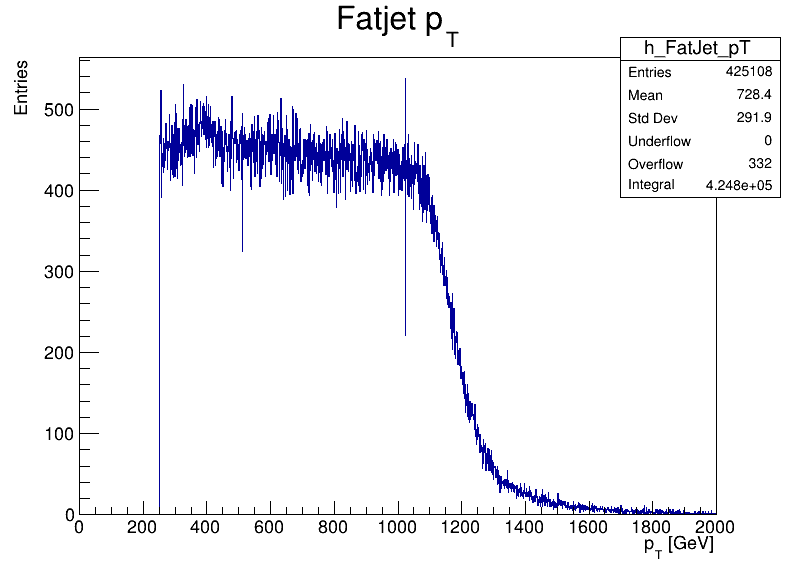

In [2]:
# start timer
start_time = time.time()

# open input NanoAOD file
f = ROOT.TFile("/STORE/matej/H3_skims/2017/XToYHTo6B_MX-2500_MY-800/F783DD8F-FD3D-3848-BC12-8A79B6143E55.root", "READ")
# get pointer to the Events tree
t = f.Get("Events")

nBins = 2000
pTmin = 0.
pTmax = 2000. 
pT_cut = 250

etaBins = 200
etaTmin = -5.
etaTmax = 5.
eta_cut = 2
    
h_FatJet_pT=ROOT.TH1F("h_FatJet_pT", "Fatjet p_{T};p_{T} [GeV];Entries", nBins, pTmin, pTmax)
h_FatJet_eta = ROOT.TH1F("h_FatJet_eta", "Fatjet eta; $\eta; Entries$", etaBins, etaTmin, etaTmax)


# total number of events
nEvents = t.GetEntries()
# loop over events
for e in range(0, nEvents):
    if e % 10000 == 0 :
        print ('Event: %i' % (e+1) )

    # get event
    t.GetEntry(e)

    # loop over fat jets
    for j in range(0, t.nFatJet):
        if t.FatJet_pt[j] > pT_cut and abs(t.FatJet_eta[j]) < eta_cut:
            h_FatJet_pT.Fill(t.FatJet_pt[j])
            h_FatJet_eta.Fill(t.FatJet_eta[j])

# stop timer
print("--- {} seconds ---".format(time.time() - start_time))

c=ROOT.TCanvas("c","The Canvas Title",800,600)
h_FatJet_pT.Draw()
c.Draw()

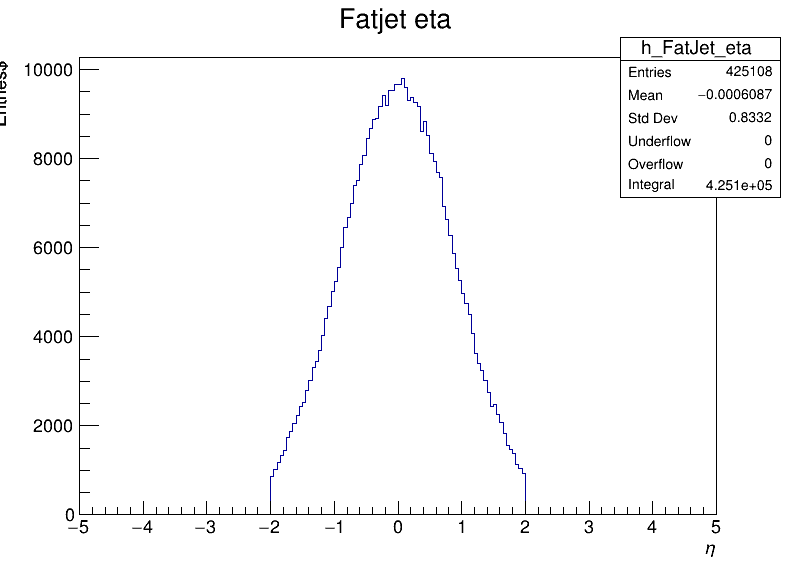

In [3]:
h_FatJet_eta.Draw()
c.Draw()

# Example of columnar analysis

/cvmfs/cms.cern.ch/el9_amd64_gcc11/external/py3-numpy/1.22.4-1e1240160543ee39175a125e9a5e9cae/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc11/external/py3-numpy/1.22.4-1e1240160543ee39175a125e9a5e9cae/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc11/external/py3-numpy/1.22.4-1e1240160543ee39175a125e9a5e9cae/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc11/external/py3-numpy/1.22.4-1e1240160543ee39175a125e9a5e9cae/lib/python3.9/site-pac

--- 4.201632738113403 seconds ---


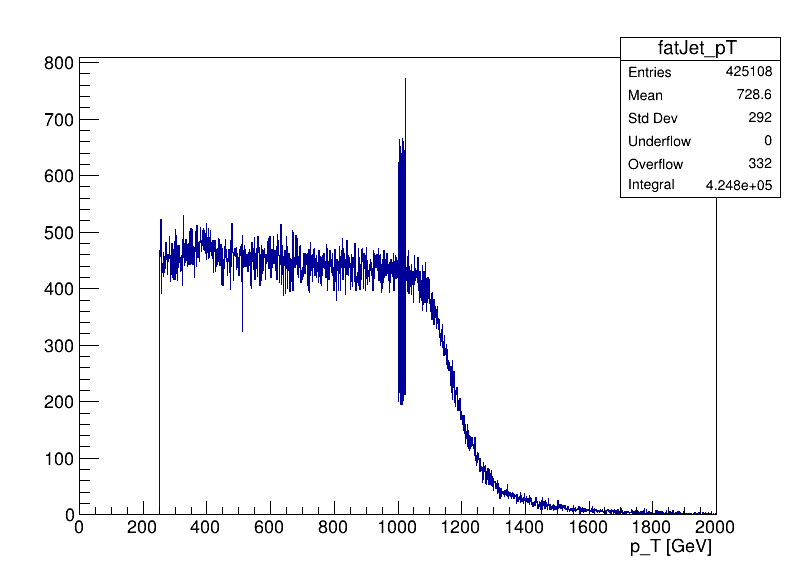

In [4]:
# start timer
start_time = time.time()

events = NanoEventsFactory.from_root("/STORE/matej/H3_skims/2017/XToYHTo6B_MX-2500_MY-800/F783DD8F-FD3D-3848-BC12-8A79B6143E55.root",schemaclass=NanoAODSchema,metadata={"dataset":""},entry_stop=None).events()

fatjets = events.FatJet

def pT_mask(fatjets):
    return fatjets.pt > pT_cut

def eta_mask(fatjets):
    return abs(fatjets.eta) < eta_cut

fatJet_sel1 = fatjets[pT_mask(fatjets)]
fatJet_sel2 = fatjets[eta_mask(fatJet_sel1)]

fatJet_pt = fatJet_sel2.pt
fatJet_eta = fatJet_sel2.eta

fatJet_pT_bin = hist.axis.Regular(label="p_T [GeV]", name="fatJet_pT", bins=nBins, start=pTmin, stop=pTmax)
fatJet_pT_hist = hist.Hist(fatJet_pT_bin, storage="weight")
fatJet_pT_hist.fill(ak.flatten(fatJet_pt))

fatJet_eta_bin = hist.axis.Regular(label="eta", name="fatJet_eta", bins=etaBins, start=etaTmin, stop=etaTmax)
fatJet_eta_hist = hist.Hist(fatJet_eta_bin, storage="weight")
fatJet_eta_hist.fill(ak.flatten(fatJet_eta))

# stop timer
print("--- {} seconds ---".format(time.time() - start_time))


with uproot.recreate("outfile.root") as fout:
    fout["fatJet_pT"] = fatJet_pT_hist
    fout["fatJet_eta"] = fatJet_eta_hist

fout = ROOT.TFile.Open("outfile.root", "READ")
h = fout.Get("fatJet_pT")
h.Draw("hist")
c.Draw()

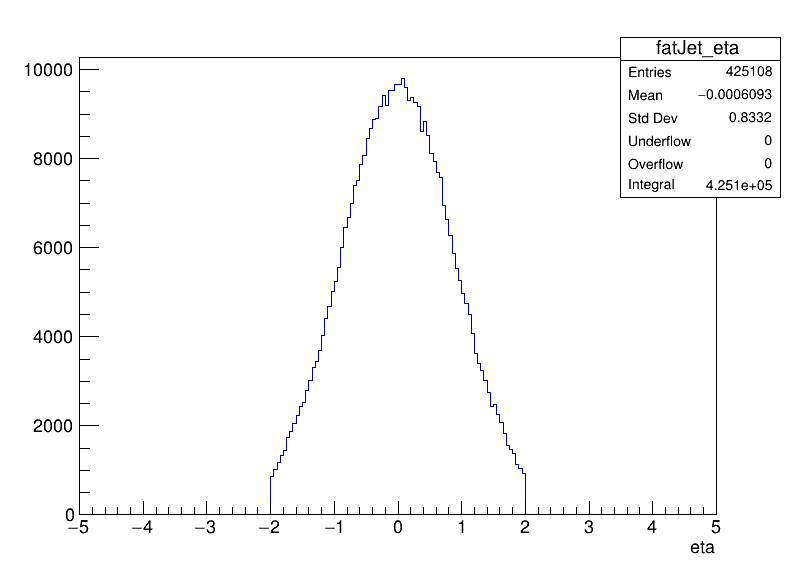

In [5]:
fout = ROOT.TFile.Open("outfile.root", "READ")
h = fout.Get("fatJet_eta")
h.Draw("hist")
c.Draw()